In [113]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [114]:
im_width = 128
im_height = 128
im_chan = 1
path_train = './train/'
path_test = './test/'

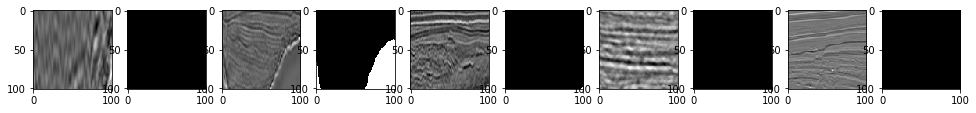

In [115]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('./train/images/' + img_name + '.png')
    img_mask = load_img('./train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [116]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [117]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Done!


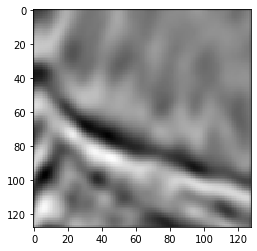

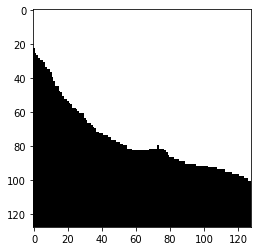

In [118]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [120]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [121]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, 128, 128, 1)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_286 (Conv2D)             (None, 128, 128, 8)  80          lambda_14[0][0]                  
__________________________________________________________________________________________________
conv2d_287 (Conv2D)             (None, 128, 128, 8)  584         conv2d_286[0][0]                 
___________________________________________________________________________________________

In [122]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 183s 51ms/step - loss: 0.5389 - val_loss: 0.5784

Epoch 00001: val_loss improved from inf to 0.57844, saving model to model-tgs-salt-1.h5
Epoch 2/30
3600/3600 [==============================] - 173s 48ms/step - loss: 0.3933 - val_loss: 0.3370

Epoch 00002: val_loss improved from 0.57844 to 0.33698, saving model to model-tgs-salt-1.h5
Epoch 3/30
3600/3600 [==============================] - 169s 47ms/step - loss: 0.3918 - val_loss: 0.3330

Epoch 00003: val_loss improved from 0.33698 to 0.33295, saving model to model-tgs-salt-1.h5
Epoch 4/30
3600/3600 [==============================] - 169s 47ms/step - loss: 0.3101 - val_loss: 0.2950

Epoch 00004: val_loss improved from 0.33295 to 0.29497, saving model to model-tgs-salt-1.h5
Epoch 5/30
3600/3600 [==============================] - 170s 47ms/step - loss: 0.2950 - val_loss: 0.3024

Epoch 00005: val_loss did not improve from 0.29497
Epoch 6/

# 원래 x(img_to_array)의 크기는 [101,101,1]이었는데, resize로 128로 늘린거

In [123]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Done!


In [127]:
X_train

array([[[[ 96],
         [108],
         [109],
         ...,
         [111],
         [111],
         [100]],

        [[112],
         [125],
         [125],
         ...,
         [128],
         [129],
         [115]],

        [[114],
         [128],
         [127],
         ...,
         [132],
         [132],
         [118]],

        ...,

        [[115],
         [130],
         [130],
         ...,
         [126],
         [126],
         [112]],

        [[101],
         [112],
         [110],
         ...,
         [116],
         [118],
         [105]],

        [[ 81],
         [ 88],
         [ 85],
         ...,
         [ 99],
         [101],
         [ 90]]],


       [[[ 96],
         [111],
         [113],
         ...,
         [165],
         [163],
         [144]],

        [[111],
         [127],
         [130],
         ...,
         [180],
         [177],
         [155]],

        [[115],
         [131],
         [133],
         ...,
         [173],
         [

In [128]:
model = load_model('model-tgs-salt-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 190s 11ms/step


In [133]:
X_train.shape

(4000, 128, 128, 1)

In [130]:
preds_train.shape

(3600, 128, 128, 1)

In [132]:
preds_train

array([[[[0.1450522 ],
         [0.06828699],
         [0.05331987],
         ...,
         [0.06092596],
         [0.0800603 ],
         [0.09082347]],

        [[0.07717061],
         [0.0461356 ],
         [0.03579751],
         ...,
         [0.05523199],
         [0.06062034],
         [0.05945769]],

        [[0.0699324 ],
         [0.04891932],
         [0.03734586],
         ...,
         [0.05687121],
         [0.06148478],
         [0.06453019]],

        ...,

        [[0.06282806],
         [0.04184628],
         [0.04320687],
         ...,
         [0.06607071],
         [0.06839287],
         [0.07990459]],

        [[0.06040204],
         [0.06634411],
         [0.06423417],
         ...,
         [0.08494821],
         [0.09064749],
         [0.10169518]],

        [[0.08967447],
         [0.06021106],
         [0.05104971],
         ...,
         [0.07953221],
         [0.08791927],
         [0.16994628]]],


       [[[0.17050394],
         [0.09693545],
         [0.07

In [134]:
preds_train_t

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [135]:
x.shape[0]

128

# 늘린 X_test를 다시 원래 이미지 크기로 바꾸는 작업(128 -> 101)

In [144]:
sizes_test[0][0]

101

In [150]:
X_test.shape[1]

128

In [137]:
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [151]:
preds_test_upsampled[0].shape

(101, 101)

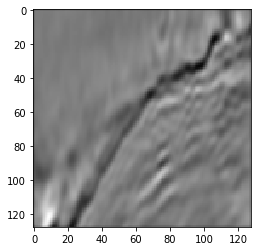

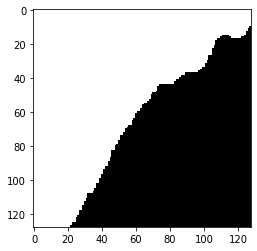

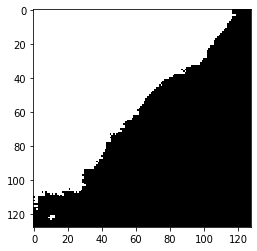

In [154]:
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
#실제 mask 이미지
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
#에측 mask 이미지
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [155]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs


In [156]:
pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [157]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [159]:
submission = pd.read_csv('submission.csv')
submission.head()

,id,rle_mask
0,dc066ad24e,8 94 107 96 210 94 311 94 412 94 513 94 616 92...
1,9ddc91e5bb,1 2626 2628 2 2635 93 2752 77 2858 72 2963 68 ...
2,ef441205b5,4447 4 4452 1 4457 1 4546 9 4557 2 4647 13 474...
3,4a723a302f,NaN
4,16545fae06,1 60 102 60 166 2 169 1 203 61 268 1 304 62 40...
